In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os

In [2]:
from sklearn.impute import KNNImputer

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [72]:
data = pd.concat([pd.read_csv('en.openfoodfacts.org.products/' + f) for f in os.listdir('en.openfoodfacts.org.products')], axis = 0).reset_index(drop=True)

C:\Users\Nabil\AppData\Local\Temp\ipykernel_18996\1242553857.py:1: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([pd.read_csv('en.openfoodfacts.org.products/' + f) for f in os.listdir('en.openfoodfacts.org.products')], axis = 0).reset_index(drop=True)
C:\Users\Nabil\AppData\Local\Temp\ipykernel_18996\1242553857.py:1: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([pd.read_csv('en.openfoodfacts.org.products/' + f) for f in os.listdir('en.openfoodfacts.org.products')], axis = 0).reset_index(drop=True)


In [73]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,5701263901480,http://world-en.openfoodfacts.org/product/5701...,date-limite-app,1494662897,2017-05-13T08:08:17Z,1494662898,2017-05-13T08:08:18Z,Hareng sauce moutarde,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41303069363,http://world-en.openfoodfacts.org/product/0041...,org-database-usda,1587640593,2020-04-23T11:16:33Z,1587640593,2020-04-23T11:16:33Z,Super fruit papaya chunks,NaN,NaN,...,NaN,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3700216223589,http://world-en.openfoodfacts.org/product/3700...,kiliweb,1584271146,2020-03-15T11:19:06Z,1592951617,2020-06-23T22:33:37Z,Acerola,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5010251774464,http://world-en.openfoodfacts.org/product/5010...,openfoodfacts-contributors,1529328989,2018-06-18T13:36:29Z,1631986249,2021-09-18T17:30:49Z,Minced beef,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8173317,http://world-en.openfoodfacts.org/product/0817...,foodrepo,1548767033,2019-01-29T13:03:53Z,1582925345,2020-02-28T21:29:05Z,Krini Pepperoni grec moyen,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <p style='text-align:center'> Nettoyage de l'energie </p>

In [74]:
energy=data[['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']].copy()
energy['energy_100g']=energy['energy_100g']*(1/4.184)
energy['energy-kj_100g']=energy['energy-kj_100g']*(1/4.184)
energy['energy_kcal_100g']=energy.apply(np.nanmean,axis=1)
data['energy_kcal_100g']=energy['energy_kcal_100g']

C:\Users\Nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\apply.py:867: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)


# <p style='text-align:center'> Selection des variables </p>

Le premier critère de choix pour la suppression des variables est le taux de complétion. Dans la pratique, une variable qui n’est pas suffisamment renseigné est difficilement exploitable. De plus, comme nous allons être amené à utiliser un KNNImputer et qu'il s'agit d'un algorithme qui, appliqué avec des variables peu renseignées ne produirai pas des résultats fiables, (Manque de données de références) on choisit de fixer un seuil minimum de complétion à 20%.

## Sélection des variable sur la base du taux de complétion

Text(0.5, 1.0, 'histogramme des taux de completion des variables')

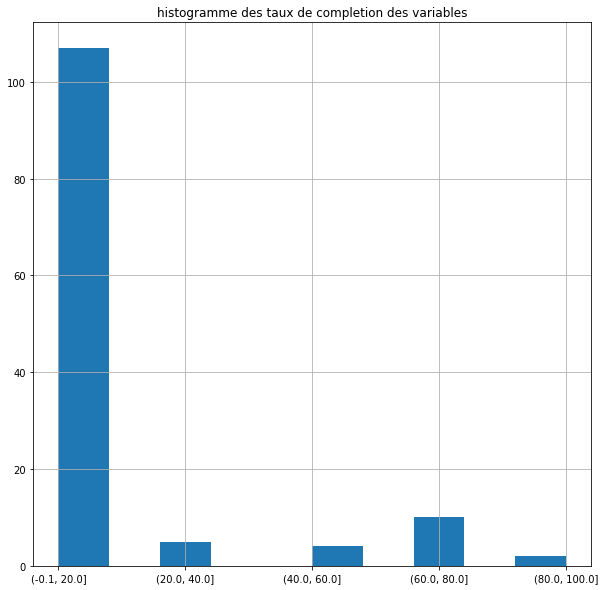

In [75]:
n_product = data.shape[0]
completion_rate = pd.DataFrame(data=((data.describe()).loc['count'])*(100/n_product))
completion_rate['slice'] = pd.cut(completion_rate['count'],5).astype('str')
completion_rate.sort_values(by="slice",ascending=True)['slice'].hist(figsize=(10,10)).set_title('histogramme des taux de completion des variables')

In [76]:
# On décide de fixer un seuil minimum de 20 % pour le taux de complétion des variables que l'on conserve. On supprime les
# variables dont le taux de complétion est inférieur à ce seuil.
min_comp_rate=20
liste_remove_1=list(completion_rate[completion_rate['count']<=min_comp_rate].index)

## La suppression des variables doublons

In [77]:
# Les variables suivantes sont des doublons de variables que nous avons choisi de conserver
liste_doublons=['created_t',
    'last_modified_t',
    'energy-kcal_100g', 
    'energy_100g',
    'main_category',
    'origins',
    'labels',
    'countries',    
    'categories_en', 
    'categories', 
    'nutriscore_score',
    'traces',
    'emb_codes', 
    'additives_n',
    'states_en']

## Selection des variables par analyse métier

In [78]:
# Notre projet d'application ne requiert pas l'utilisations des variables tags suivantes
liste_tags=['emb_codes_tags',
    'labels_tags',
    'countries_tags',
    'origins_tags', 
    'additives_tags',
    'manufacturing_places_tags',
    'ingredients_from_palm_oil_tags', 
    'ingredients_that_may_be_from_palm_oil_tags',
    'states_tags',
    'brands_tags',
    'categories_tags', 
    'packaging_tags',
    'traces_tags']

In [79]:
# Les variables suivantes ne sont pas pertinentes pour notre projet d'application 
liste_irrelevants_variables=['image_url',
    'image_ingredients_url',
    'image_ingredients_small_url', 
    'image_nutrition_url', 
    'image_nutrition_small_url',
    'ingredients_that_may_be_from_palm_oil_n', 
    'creator',
    'brand_owner',
    'abbreviated_product_name',
    'generic_name',
    'packaging',
    'quantity',
    'serving_size', 
    'serving_quantity', 
    'pnns_groups_1',
    'packaging_text']

In [80]:
column_to_keep=list(data.columns)
liste_remove= liste_remove_1 + liste_doublons+liste_tags+liste_irrelevants_variables
for item in liste_remove:
    column_to_keep.remove(item)
print(column_to_keep)

['code', 'url', 'created_datetime', 'last_modified_datetime', 'product_name', 'brands', 'origins_en', 'manufacturing_places', 'labels_en', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries_en', 'ingredients_text', 'allergens', 'traces_en', 'additives_en', 'ingredients_from_palm_oil_n', 'nutriscore_grade', 'nova_group', 'pnns_groups_2', 'states', 'ecoscore_grade_fr', 'main_category_en', 'image_small_url', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g', 'energy_kcal_100g']


In [81]:
# On filtre les variables dont on a pas besoin
data_2=data[column_to_keep]

# <p style='text-align:center'> Vérification des valeurs abbérentes </p>

Pour des raisons évidentes, les données nutritionnelles qui sont quantifiées en gramme sur 100g de chaque produit ne peuvent pas dépasser 100. Par exemple la variable fat_100g qui correspond à la quantité de matières grasses pour 100g de produit ne peux pas valoir 130g. De même on sait que l'energie en kcal ne peut dépasser 900 kcal (limite maximal d'energie pour 100g d'un produit). Des valeurs qui ne respecteraient pas ces conditions sont des valeurs abbérentes. La partie qui suit à pour but de les supprimer de notre dataset.

In [82]:
limits={'fat_100g':[0,100],'saturated-fat_100g':[0,100],'sodium_100g':[0,100],'carbohydrates_100g':[0,100],'sugars_100g':[0,100],'fiber_100g':[0,100],'proteins_100g':[0,100],'salt_100g':[0,100],'sodium_100g':[0,100], 'fruits-vegetables-nuts-estimate-from-ingredients_100g':[0,100],'nutrition-score-fr_100g':[-15,40],'energy_kcal_100g':[0,900]}

In [83]:
for key in limits:
    data_2[key] = data_2[key].apply(lambda r: float("nan") if((r>limits[key][1])|(r<limits[key][0])) else r)

C:\Users\Nabil\AppData\Local\Temp\ipykernel_18996\1214505524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2[key] = data_2[key].apply(lambda r: float("nan") if((r>limits[key][1])|(r<limits[key][0])) else r)


# <p style='text-align:center'> Nettoyage des observations</p>

In [84]:
#### On récupère les données nutritionnelles des différents produits 
column_nutrition=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g', 'energy_kcal_100g']
data_nut=data[column_nutrition]

<AxesSubplot:>

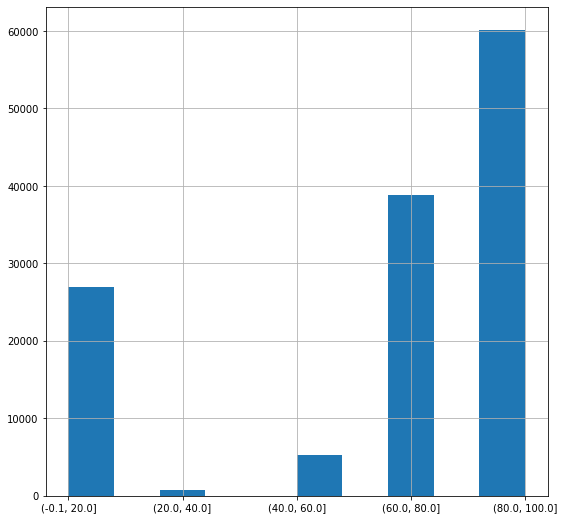

In [85]:
vert_comp_rate=pd.DataFrame(data=data_nut.count(axis=1)*(100/data_nut.shape[1]),columns=['comp_rate'])
vert_comp_rate['slice']=(pd.cut(vert_comp_rate['comp_rate'],5)).astype('str')
vert_comp_rate.sort_values(by="slice",ascending=True)['slice'].hist(figsize=(9,9))

Nous allons utiliser un algorithme KNN_IMPUTER pour remplir les données nutritionnelles manquantes chez certains produits (observations)
L'idée est simple, lorsqu'un aliment a des données nutritionnelles non renseignées, on remplace les valeurs manquantes par la 
moyenne de celle de ces k "plus proches voisins", c'est à dire les k aliments qui ont les données nutritionnelles les plus proches au sens d'une métrique bien définie (dans notre cas, la métrique euclidiennes.
Pour un aliment donnée, plus on a de données nutritionnelles, plus on l'identifie facilement, donc plus les voisins qui lui sont attribué par le KNN ont de chance de correspondre au même aliment.
En raisonnant de cette façon, on déduit que si on a trop peu de données nutritionnelles renseignées pour un aliment, il sera associer à des voisins qui ne correspondent pas au même aliment.
C'est pourquoi nous allons fixer un seuil minimum au taux de complétion des données nutritionnelles à nos observations.
On fait le choix de le fixer à 40%.

In [87]:
seuil_cr_nutrition_data=40
liste_remove_observations=list(vert_comp_rate[vert_comp_rate['comp_rate']<=seuil_cr_nutrition_data].index)
data_3=(data_2.drop(liste_remove_observations)).reset_index(drop=True)

In [89]:
# data_3 = data_3.sample(n=100000).reset_index()

In [90]:
column_nutrition=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','sodium_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g','nutrition-score-fr_100g','energy_kcal_100g']
data_nutrition = data_3[column_nutrition]

In [91]:
scaler = MinMaxScaler()

In [92]:
data_nutrition_scaled=pd.DataFrame(scaler.fit_transform(X=data_nutrition.values),columns=column_nutrition)

# Gestion des  outliers

In [93]:
data_outlier=data_3[['pnns_groups_2','fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','sodium_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g','nutrition-score-fr_100g','energy_kcal_100g']]

In [94]:
# data_outlier.groupby('pnns_groups_2').mean()

In [95]:
# data_outlier.groupby('pnns_groups_2').median()

Text(0.5, 0.98, 'boxplot de la variable fat_100g en fonction de quelques pnns_groups_2')

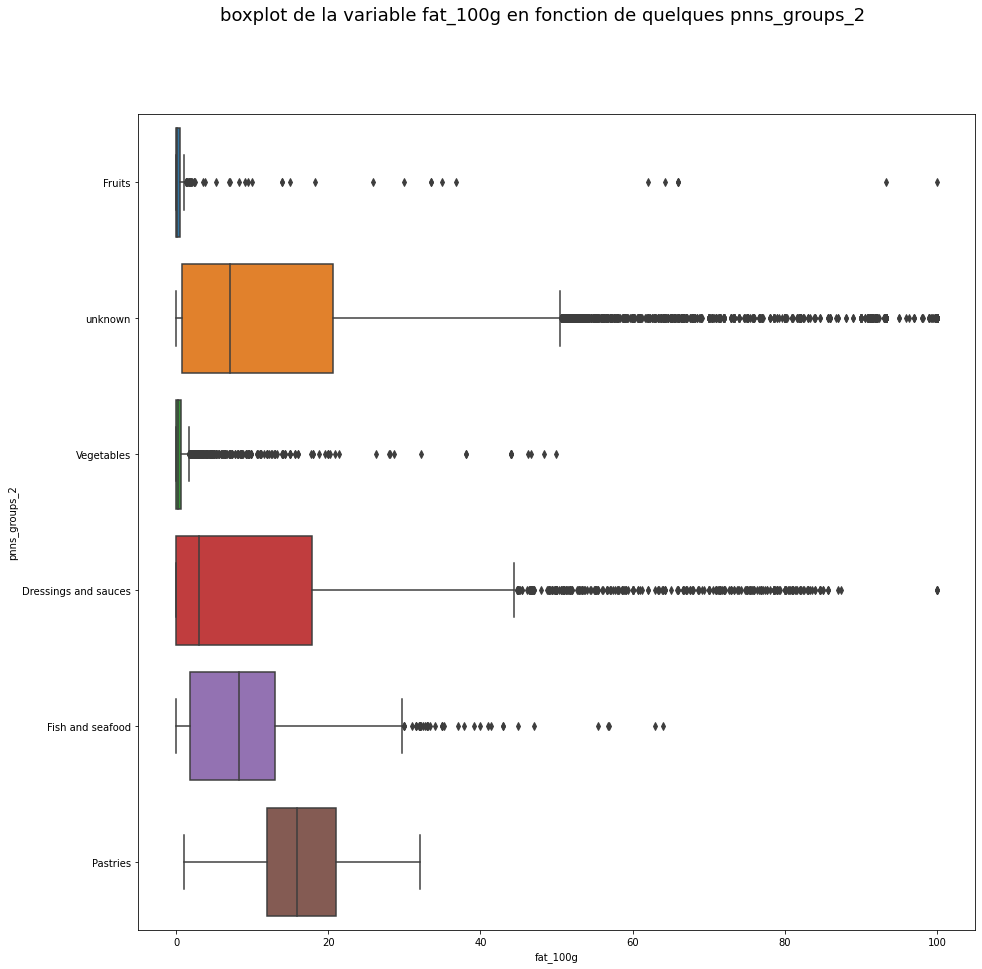

In [96]:
plt.subplots(figsize=(15,15))
sns.boxplot(x="fat_100g",y="pnns_groups_2",data=data_outlier[data_outlier['pnns_groups_2'].isin(['unknown','Dressings and sauces','Fish and seafood','Fruits','Pastries','Vegetables'])])
plt.suptitle('boxplot de la variable fat_100g en fonction de quelques pnns_groups_2',size=18)

In [97]:
data[data['pnns_groups_2']=='Vegetables'].sort_values('fat_100g',ascending=False).head()#[['product_name','fat_100g']]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,energy_kcal_100g
41847,1108310509646,http://world-en.openfoodfacts.org/product/1108...,kiliweb,1619711102,2021-04-29T15:45:02Z,1631198475,2021-09-09T14:41:15Z,Tomate côtelée,NaN,NaN,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978011
22426,3760253401074,http://world-en.openfoodfacts.org/product/3760...,kiliweb,1610740165,2021-01-15T19:49:25Z,1631199156,2021-09-09T14:52:36Z,Tomates séchées et origan,NaN,NaN,...,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,548.020076
14831,62781067771,http://world-en.openfoodfacts.org/product/0062...,kiliweb,1583875455,2020-03-10T21:24:15Z,1603105329,2020-10-19T11:02:09Z,Oignons frits,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,633.349267
30685,3760087360998,http://world-en.openfoodfacts.org/product/3760...,kiliweb,1498494949,2017-06-26T16:35:49Z,1620370655,2021-05-07T06:57:35Z,Fèves de Cacao entières crues et non torréfiées,NaN,Fèves de cacao,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,559.236711
106234,27041642,http://world-en.openfoodfacts.org/product/2704...,kiliweb,1535057421,2018-08-23T20:50:21Z,1603105282,2020-10-19T11:01:22Z,Oignons Frits,NaN,NaN,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,590.052581


Text(0.5, 0.98, 'boxplot de la variable fat_100g en fonction de quelques pnns_groups_2')

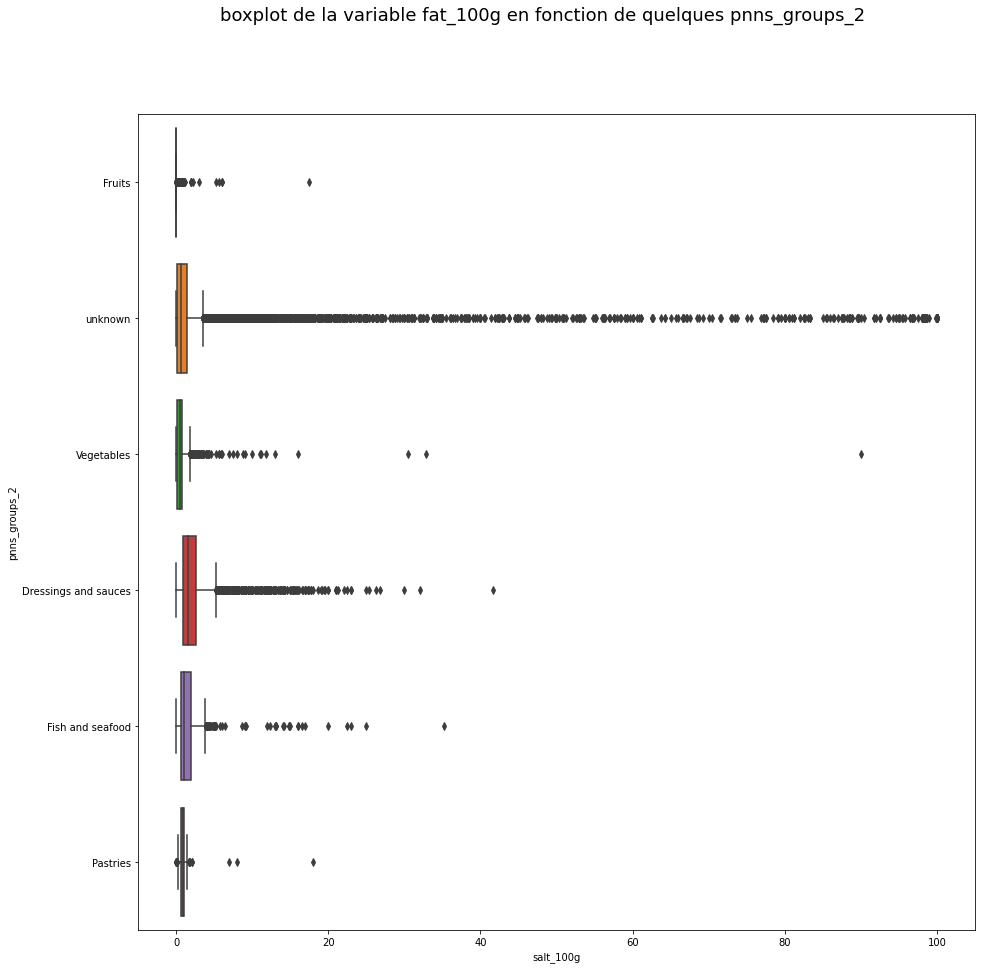

In [98]:
plt.subplots(figsize=(15,15))
sns.boxplot(x="salt_100g",y="pnns_groups_2",data=data_outlier[data_outlier['pnns_groups_2'].isin(['unknown','Dressings and sauces','Fish and seafood','Fruits','Pastries','Vegetables'])])
plt.suptitle('boxplot de la variable fat_100g en fonction de quelques pnns_groups_2',size=18)

# Complétion des données

In [99]:
knn_imputer = KNNImputer(n_neighbors=2)

In [100]:
data_nutrition_imputed=knn_imputer.fit_transform(data_nutrition_scaled)

In [101]:
data_inputed_non_scaled=scaler.inverse_transform(data_nutrition_imputed)

In [102]:
data_inputed_non_scaled=pd.DataFrame(data_inputed_non_scaled,columns=column_nutrition) 

In [103]:
data_imputed=pd.concat([data_3[['code', 'url', 'created_datetime', 'last_modified_datetime','product_name', 'brands', 'origins_en', 'manufacturing_places','labels_en', 'first_packaging_code_geo', 'cities_tags','purchase_places', 'stores', 'countries_en', 'ingredients_text','allergens', 'traces_en', 'additives_en', 'ingredients_from_palm_oil_n','nutriscore_grade', 'nova_group', 'pnns_groups_2', 'states','ecoscore_grade_fr', 'main_category_en', 'image_small_url']],data_inputed_non_scaled],axis=1)

In [104]:
data_imputed.shape

(104332, 37)

In [107]:
n_split = 10
n = data_imputed.shape[0]
filecount = 1
p = n//int(n_split)
for i in range(n):
    if i % p == 0:
        data_imputed.iloc[i:i+p].to_csv('cleaned_data/cleaned_data.csv'.replace(".csv","_") + str(filecount) + '.csv', index = False)
        filecount += 1